In [1]:
import tarfile
import os
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_dataset(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join( housing_path, "housing.tgz") 
    urllib.request.urlretrieve( housing_url, tgz_path) 
    housing_tgz = tarfile.open( tgz_path) 
    housing_tgz.extractall( path = housing_path) 
    housing_tgz.close()

In [4]:
fetch_dataset()

In [5]:
import pandas as pd
def load_dataset(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_dataset()

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


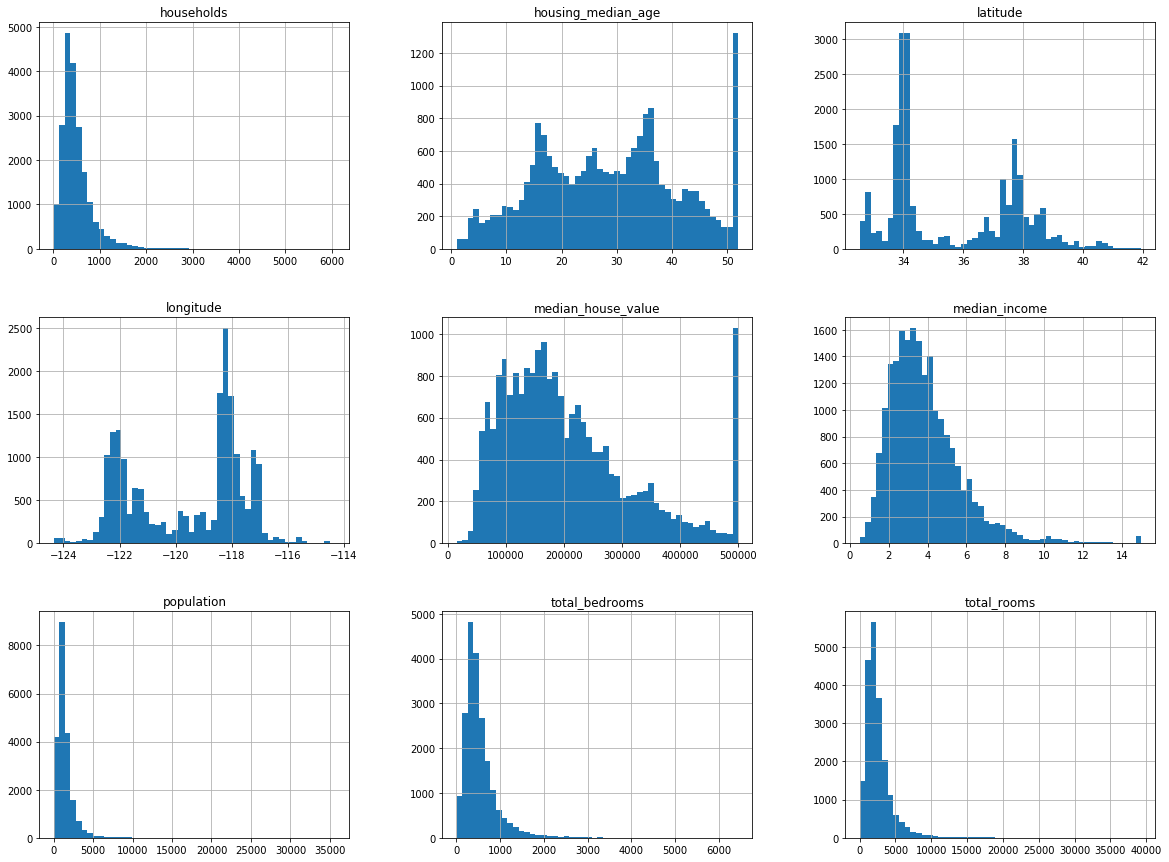

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

In [12]:
# create a test set
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
print("train set size is: ",len(train_set))
print("test set size is: ",len(test_set))

train set size is:  16512
test set size is:  4128


In [14]:
from zlib import crc32 
def test_set_check( identifier, test_ratio):
    return crc32( np.int64( identifier)) & 0xffffffff < test_ratio * 2** 32 

def split_train_test_by_id( data, test_ratio, id_column):
    ids = data[ id_column] 
    in_test_set = ids.apply( lambda id_: test_set_check( id_, test_ratio)) 
    return data.loc[ ~ in_test_set], data.loc[ in_test_set]

In [15]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id( housing_with_id, 0.2, "index")

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] 
train_set, test_set = split_train_test_by_id( housing_with_id, 0.2, "id")

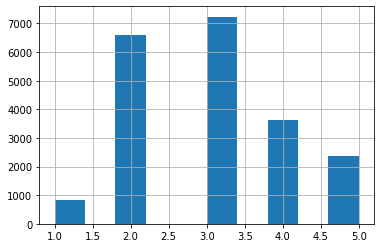

In [17]:
# adding a column housing[income_cat]
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].hist()

In [18]:
# stratified sampling

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit( n_splits=1, test_size=0.2, random_state=42 )
for train_idx, test_idx in split.split( housing, housing['income_cat'] ):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [20]:
for set_ in ( strat_train_set, strat_test_set ):
    set_.drop("income_cat", axis=1, inplace=True)

In [21]:
housing = strat_train_set.copy()

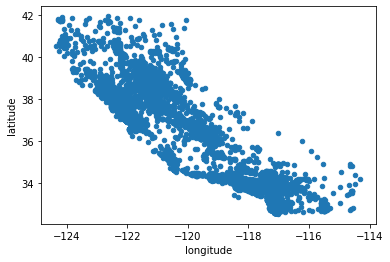

In [22]:
housing.plot( kind="scatter", x="longitude", y="latitude" )

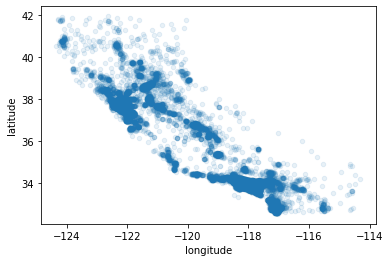

In [23]:
housing.plot( kind="scatter", x="longitude", y="latitude", alpha=0.1 )

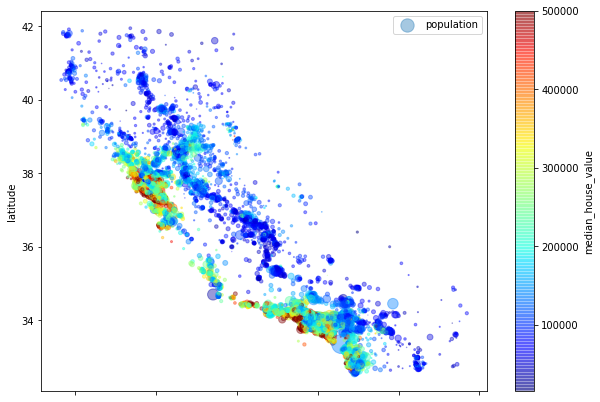

In [28]:
housing.plot( kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing['population']/100, label="population",
             figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar='True' )
plt.legend()

In [29]:
corr_matrix = housing.corr()

In [31]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [32]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AFF586B70>,
      dtype=object)

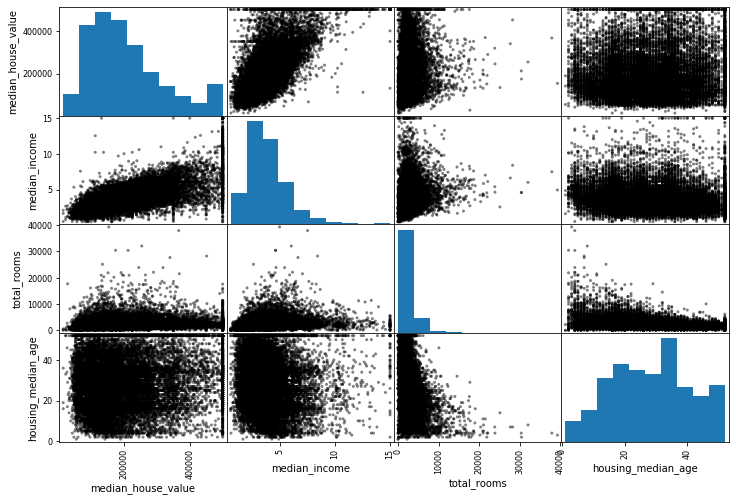

In [36]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8), color="black")

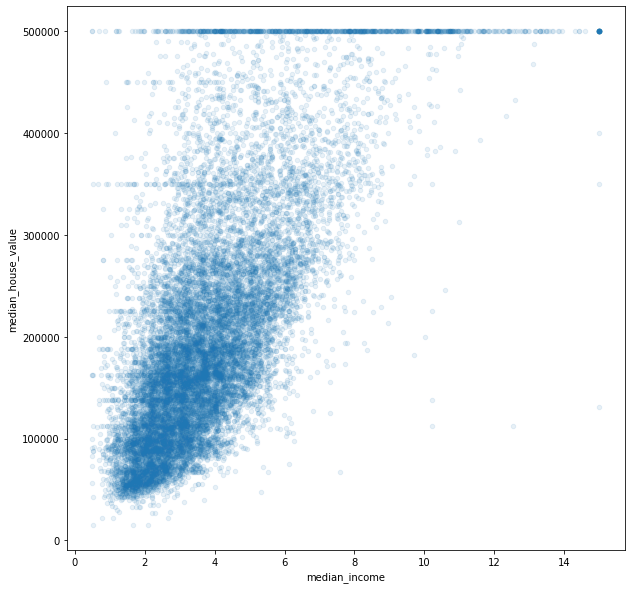

In [50]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1,figsize=(10,10))

In [55]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [53]:
housing["rooms_per_household"] = housing["total_rooms"]/ housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/ housing["total_rooms"] 
housing["population_per_household"] = housing["population"]/ housing["households"]

In [56]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.028345,0.095603,-0.000410
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,0.107621,-0.116884,0.005420
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.147186,0.136788,0.015031
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.127519,-0.192606,-0.024810
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.000377,0.086960,-0.028370
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,-0.074692,0.037778,0.076225
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,-0.083009,0.067162,-0.027416
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.311563,-0.624674,0.021822
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.146285,-0.259984,-0.021985
rooms_per_household,-0.028345,0.107621,-0.147186,0.127519,0.000377,-0.074692,-0.083009,0.311563,0.146285,1.000000,-0.398546,-0.005314


In [58]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64